# Fitting a model to data with outliers using MCMC

We are often faced with data with spurious outliers. For example, a light curve generated from some automated photometric pipeline with failures in the background subtraction on some nights. It is tempting to remove these outliers by eye, or by some automatic procedure (e.g., [sigma clipping](http://www.starlink.ac.uk/docs/sun139.htx/node83.html), however these points may actually contain valuable information. Your model should be able to account for these data! Luckily, it is relatively easy to account for this within a statistical model: the data are modeled as being either drawn from your physical model, or an outlier model with an extra parameter to specify the global weights of these two distributions.

Below we consider a trivial but illustrative example. This problem is described in a little more detail in Section 5.6.7 of [Statistics, Data Mining, and Machine Learning in Astronomy](http://www.astroml.org/). Another good reference is David Hogg's [Fitting a model to data](http://arxiv.org/abs/1008.4686) paper.

## Example data: Photometry of a variable star reduced with buggy pipeline

For this example, let's say we take images of a variable star at random times over the course of a year. We have some automated pipeline that reduces the data, and spits out magnitudes for each observation. Some nights, the pipeline fails, but the way in which we estimate uncertainties on the measured magnitudes doesn't account for these failures, leading to outliers in the final data product (a light curve). For now, we'll assume the true shape of the light curve is a perfect sinusoid, but in principle any template could be used. Our goal will be to estimate the amplitude, period, and phase of the sinusoid, plus uncertanties on all of these, given noisy observations of the star.

In addition to "the usual" *matplotlib* and *numpy* packages, we will also use the [*emcee*](http://dan.iel.fm/emcee/current/) package to do the stats and [*triangle*](https://github.com/dfm/triangle.py) module to visualize the results.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.misc import logsumexp
import emcee
import triangle

We start by definining some helper functions to generate the fake data:

In [2]:
def sinusoid(t, amp, period, cosphase):
    """ A generic sinusoidal curve. 'period' and 't' should have 
        the same units (e.g., days), and phase should be in
        radians. 
        
        Parameters
        ----------
        t : array_like
            Array of times.
        amp : numeric
            Amplitude of the sinusoid.
        period : numeric
            Period of the sinusoid.
        cos_phase : numeric
            Cosine of the phase of the sinusoid.
    """
    a = 2*np.pi*t/period
    sinphase = np.sqrt(1 - cosphase**2)
    return amp*np.sin(a)*cosphase + np.cos(a)*sinphase

def light_curve_model(p, t):
    """ Our model for the variable star light curve will be a 
        pure sinusoid plus some constant offset (the mean 
        magnitude of the star). The function takes a single array
        of parameters, p, and an array of times, t. By structuring
        the function input parameters this way, we can use this 
        function to both generate and later fit the data.
        
        Parameters
        ----------
        p : iterable
            A list, tuple, or array of model parameter values. For
            example, a tuple of (amplitude, period, cosphase, mean mag.).
        t : array_like
            Array of times.
    """
    amp, period, cosphase, const = p
    return sinusoid(t, amp, period, cosphase) + const

Now we'll actually generate the fake data. The cell below contains tunable parameters -- if you want to change the number of data points, the fraction of points that are outliers, or the true model parameters, modify the variables in this cell:

In [3]:
np.random.seed(2) # seed the random number generator so it produces the same data if re-run
ndata_points = 64 # number of data points
outlier_fraction = 0.1 # 10% of the points will be outliers

true_amplitude = 1.5 # mag
true_period = 112. # days
true_cosphase = np.cos(1.5) # phase in radians
true_mean_mag = 14. # mag

# we'll use this later for plotting
extents = [(0,5), (82,142), (-1,1), (10,20)]

In [4]:
# pack the true parameters into a single tuple
true_params = (true_amplitude, true_period, true_cosphase, true_mean_mag)

# generate an array of observation times as day number
time = np.random.uniform(0., 365., size=ndata_points)
time.sort()

# generate measured magnitude values from the model at the observation times
mag = light_curve_model(true_params, time)

# each magnitude data point will have a different uncertainty, sampled from 
#    a uniform distribution between 0.2 and 0.4 magnitudes
mag_err = np.random.uniform(0.1, 0.3, size=ndata_points)

# pick outlier points based on the set outlier_fraction. we generate a
#    boolean array (array of True's and False's) -- when a given index
#    is True, that point will become an outlier
outlier_idx = np.random.uniform(size=ndata_points) < outlier_fraction

# for the outlier points, add large scatter
mag[outlier_idx] += np.random.normal(0., 4., size=sum(outlier_idx))

# for the non-outlier points, add scatter based on the uncertainty array (mag_err).
#    the twiddle (~) means 'logical not' - (True becomes False, False becomes True) 
mag[~outlier_idx] += np.random.normal(0., mag_err[~outlier_idx])

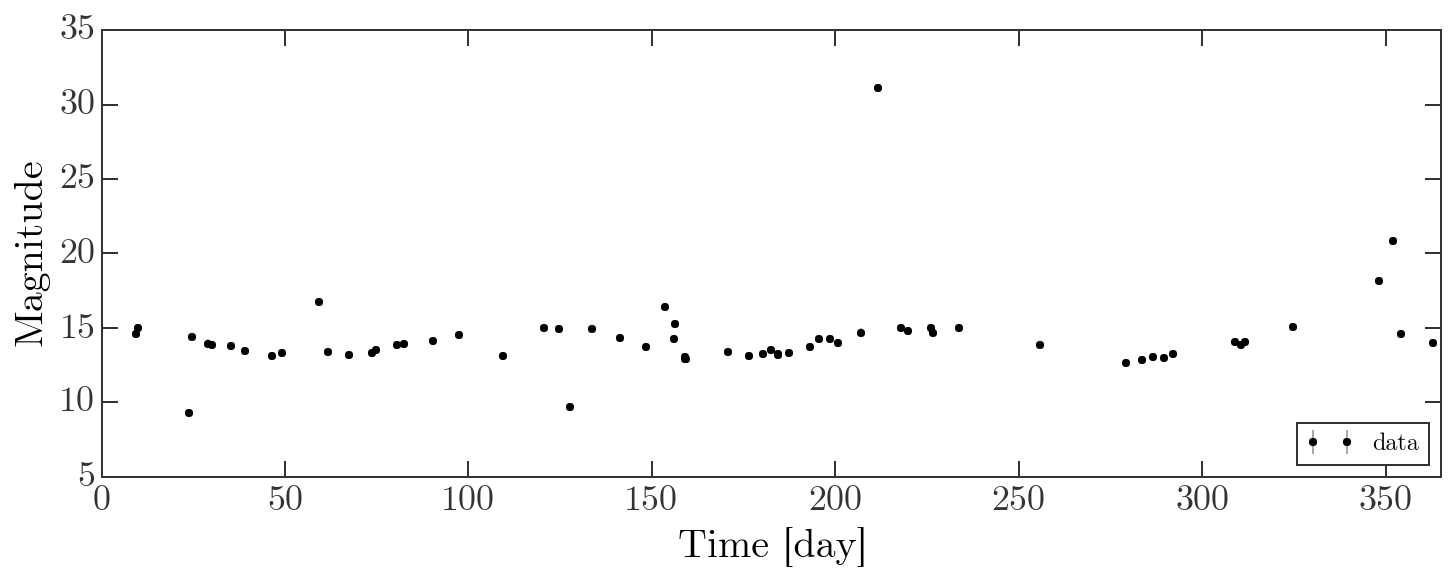

In [5]:
plt.figure(figsize=(12,4))
plt.errorbar(time, mag, mag_err, marker='o', capsize=0, color='k', markersize=4,
             linestyle='none', ecolor='#aaaaaa', label='data')
plt.xlim(0,365)
plt.xlabel("Time [day]", size=20)
plt.ylabel("Magnitude", size=20)
plt.legend(loc='lower right')

---

Now we're armed with some fake data in the form of 3 arrays: the observation times, magnitudes, and uncertainties for the magnitudes (we'll assume we can measure the time of observation to arbitrary precision). We'll start by trying to fit our light curve model _without_ taking into account the outliers. We're going to use the same model that we used to generate the data, but ignore the fact that there are outlier points.

We assume that each data point is independent, has Gaussian uncertainties (as we have done by construction), and are drawn from a Gaussian around some true model with the parameters amplitude, $A$, period, $T$, phase, $\phi$, and mean magnitude, $m_0$. The expression for the likelihood for each $i$ data point can be expressed as a Gaussian:


$$
p(m_i \,\vert\, A,T,\phi,m_0,\sigma_{m,i},t_i) = \frac{1}{\sqrt{2\pi\sigma_{m,i}^2}} \exp \left(-\frac{(m_i - f(t_i, A, T, \phi, m_0))^2}{2\sigma_{m,i}^2}\right)
$$

where our light curve model is expressed as the function $f$:

$$
f(t_i, A, T, \phi, m_0) = A\sin(\frac{2\pi t_i}{T}+\phi) - m_0.
$$

The full likelihood (over all data points) is then the product of these of the individual probabilities:

$$
\mathcal{L} = \prod_i^N p(m_i \,\vert\, A,T,\phi,m_0,\sigma_{m,i},t_i) = p(\{m_i\}_N \,\vert\, A,T,\phi,m_0,\{\sigma_{m,i}\}_N,\{t_i\}_N)
$$
where the notation $\{m_i\}_N$ means the set of all $N$ data points.

For this example, we will assume uniform priors over all parameters, $p(A)\,p(T)\,p(\phi)\,p(m_0)$. It is a __bad idea__ to define uniform priors over angular parameters (like the phase, $\phi$, in this example), but I've done it anyway for simplicity. In this case, we could just maximize this likelihood to find the "best fit" parameters, but instead we will use MCMC to sample from the posterior probability over the model parameters. The full posterior probability for our model is then given by:

$$
p(A,T,\phi,m_0 \,\vert\, \{m_i\}_N, \{\sigma_{m,i}\}_N, \{t_i\}_N) = \frac{1}{\mathcal{Z}} p(\{m_i\}_N \,\vert\, A,T,\phi,m_0,\{\sigma_{m,i}\}_N,\{t_i\}_N)\,p(A)\,p(T)\,p(\phi)\,p(m_0)
$$

where the constant, $\mathcal{Z}$, only depends on the properties of the data -- which we are not varying -- and thus we can ignore it for optimization. 

In practice, evaluating the logarithm of the posterior is often more stable to numerical issues (e.g., overflow or underflow), so below we define functions to evaluate the log of all of the above probabilities. This, combined with using uniform priors means that the priors evaluate to 0 when a value is outside of the specified range and are constant within the defined range. 

In [6]:
def lnprior1(p):
    amp,period,cosphase,const = p
    
    if amp < 0 or amp > 5:
        return -np.inf
    
    if period < 10 or period > 200:
        return -np.inf
    
    if cosphase < -1. or cosphase > 1:
        return -np.inf
    
    if const < 12 or const > 16:
        return -np.inf
    
    return 0.

def lnlikelihood1(p, t, data, err):
    amp,period,cosphase,const = p
    return -np.log(err) - 0.5*( (data - sinusoid(t, amp, period, cosphase) - const) / err )**2

def lnprob1(p, t, data, err):
    lp = lnprior1(p)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + np.sum(lnlikelihood1(p, t, data, err))

In [7]:
# Set the number of walkers and their initial positions, p0 ('p_naught').
ndim, nwalkers = 4, 32
p0 = np.zeros((nwalkers,ndim))
p0[:,0] = np.random.uniform(1, 2., size=nwalkers) # amp
p0[:,1] = np.random.uniform(10, 200., size=nwalkers) # period (days)
p0[:,2] = np.random.uniform(-1, 1, size=nwalkers) # cosine phase
p0[:,3] = np.random.uniform(12., 16., size=nwalkers) # const. offset (mag)

# Initialize the sampler object for the first model
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, 
                                args=(time,mag,mag_err))

In [8]:
# start the MCMC, take 1000 steps for burn in, starting from p0.
pos, prob, state = sampler1.run_mcmc(p0, 1000)

# Find highest probabilty sample
best_pos = sampler1.flatchain[sampler1.flatlnprobability.argmax()]

# Initialize new walker positions in a small volume around best sample
pos = emcee.utils.sample_ball(best_pos, best_pos/100., size=nwalkers)

# Burn in again, starting from pos
sampler1.reset()
pos_burn, prob_burn, state_burn = sampler1.run_mcmc(pos, 100)

# Erase the burn in and take 1000 steps for primary sampling.
sampler1.reset()
pos, prob, state = sampler1.run_mcmc(pos_burn, 1000)

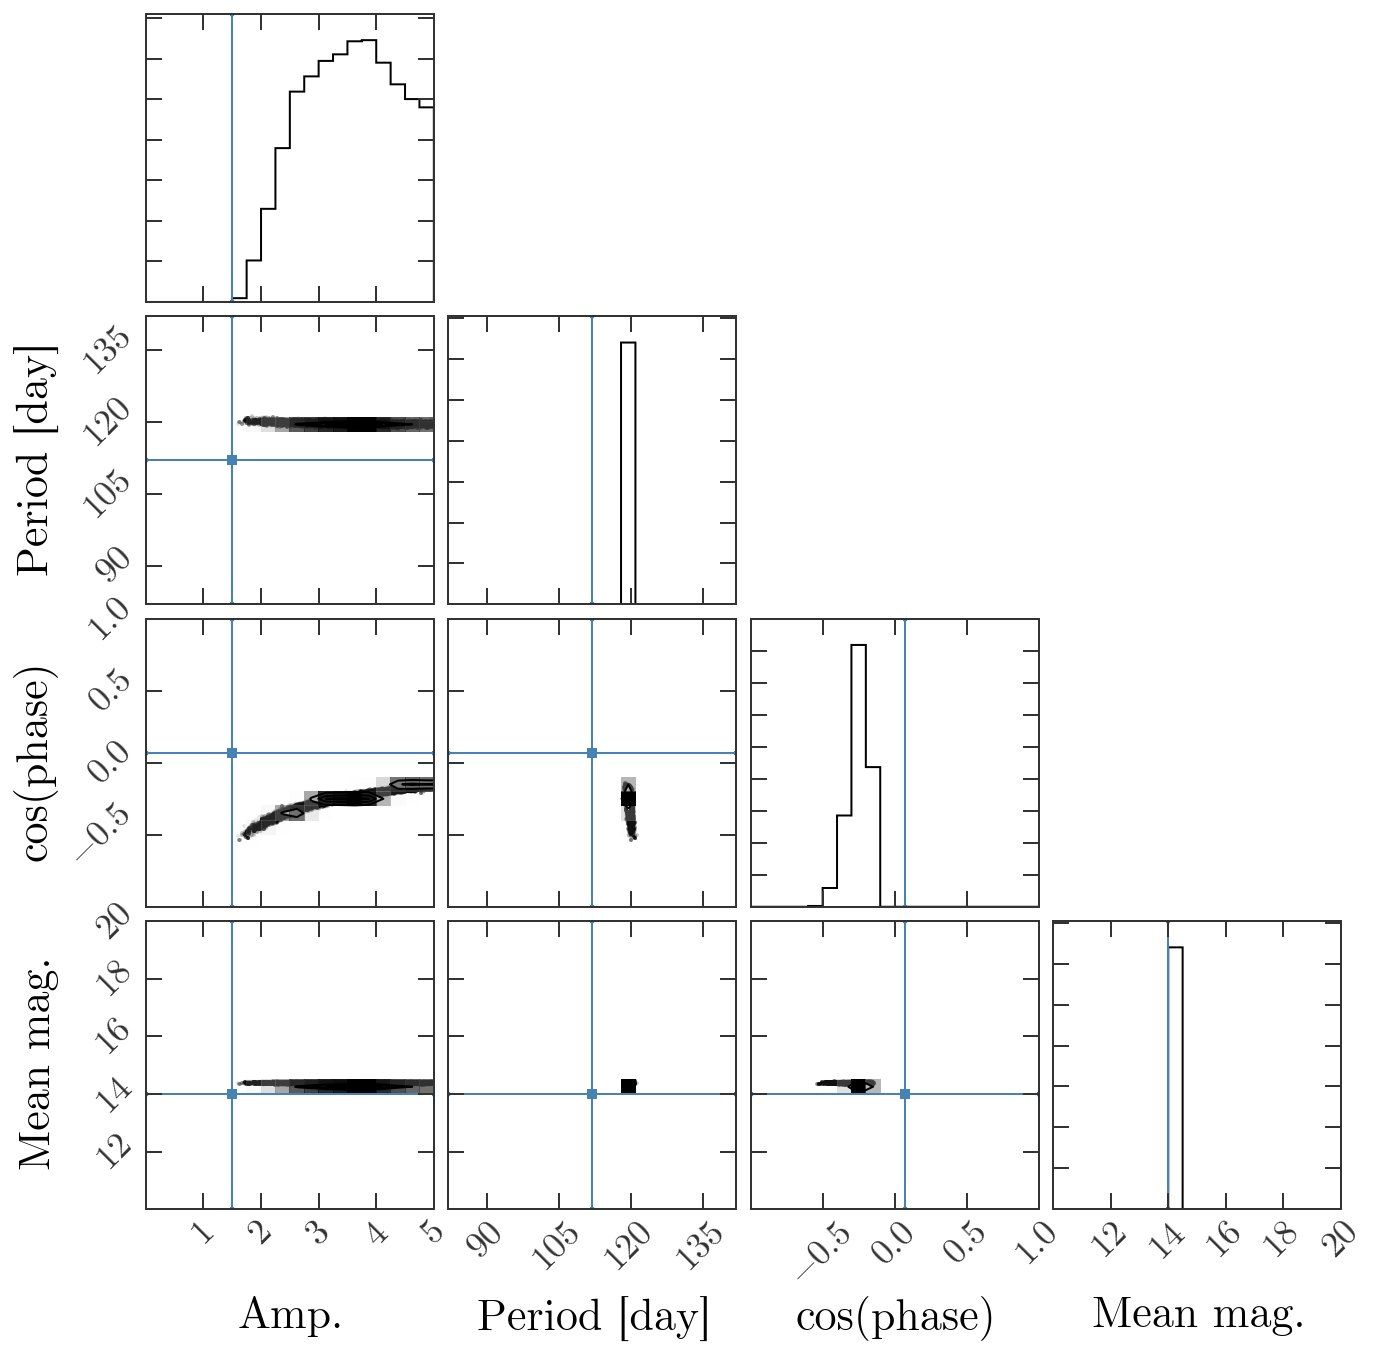

In [9]:
# Use triangle package to plot the projections of the posterior sample density and the true values 
param_labels = ["Amp.", "Period [day]", "cos(phase)", "Mean mag."]
fig = triangle.corner(sampler1.flatchain, 
                      labels=param_labels,
                      truths=true_params,
                      range=extents)

Everybody's results will be different here, but odds are, the results (contours), are similar to the true values (blue lines), but not quite right.

Let's overplot 10 different models whose parameters are randomly chosen from these posterior samples to visualize how well/poorly the model fits the data.

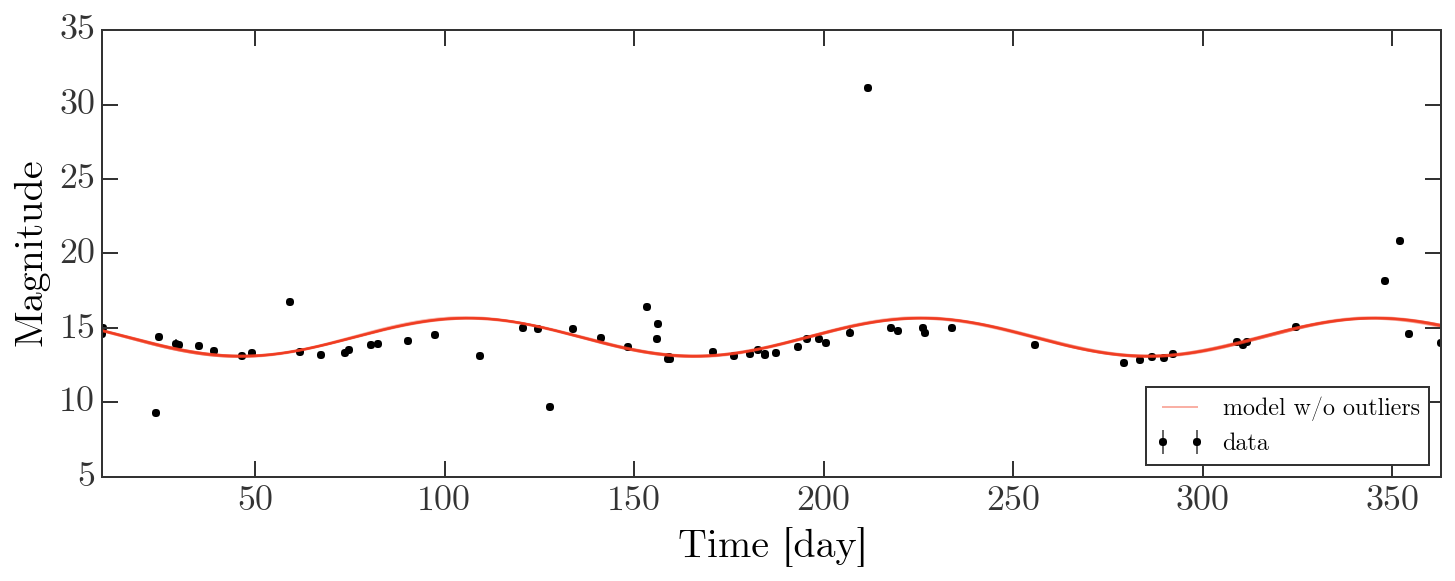

In [10]:
# Find total number of samples
nsamples = sampler1.flatchain.shape[0]

plt.figure(figsize=(12,4))
plt.errorbar(time, mag, mag_err, marker='o', capsize=0, color='k', markersize=4,
             linestyle='none', ecolor='#666666', label='data')

t = np.linspace(min(time), max(time), 1000)
for i_model in range(10):
    idx = np.random.randint(0, nsamples)
    params_1 = sampler1.flatchain[idx]
    model_mag_1 = light_curve_model(params_1, t)
    if i_model == 9:
        plt.plot(t, model_mag_1, 
             marker=None, color='#f03b20', alpha=0.4, label='model w/o outliers')
    else:
        plt.plot(t, model_mag_1, 
             marker=None, color='#f03b20', alpha=0.4)
        
plt.xlim(min(time), max(time))
plt.xlabel("Time [day]", size=20)
plt.ylabel("Magnitude", size=20)
plt.legend(loc='lower right')

What can we do about the bias in our inferred parameters and resulting relatively poor fit? 

We can define a mixture model! We add a new parameter to the model: the fraction of stars that are instead drawn from some very broad outlier distribution. There are many possible options for that to put in for this outlier distribution, but below we will assume that the outlier distribution is still centered on the model, but with a huge variance. Our "inlier" distribution will be the same as above:

$$
p_{\rm in} = p(m_i \,\vert\, A,T,\phi,m_0,\sigma_{m,i},t_i) = \frac{1}{\sqrt{2\pi\sigma_{m,i}^2}} \exp \left(-\frac{(m_i - f(t_i, A, T, \phi, m_0))^2}{2\sigma_{m,i}^2}\right)
$$

and our outlier distribution:

$$
p_{\rm out} = p(m_i \,\vert\, A,T,\phi,m_0,V,t_i) = \frac{1}{\sqrt{2\pi V}} \exp \left(-\frac{(m_i - f(t_i, A, T, \phi, m_0))^2}{2 V}\right)
$$

where $V$ is arbitrarily fixed to be 10 times the median uncertainty of the data. The new likelihood for a single point is then:

$$
\mathcal{L}_i = (1-f_{\rm bad})p_{\rm in} + f_{\rm bad}p_{\rm out}
$$

$f_{\rm out}$ represents the fraction of the data points that are outliers, and this will be a new parameter in the model.

In [11]:
# do everything again, but this time with extra f_out parameter
def lnprior2(p):
    amp = p[0]
    period = p[1]
    cosphase = p[2]
    const = p[3]
    fout = p[4]
    
    if amp < 0 or amp > 5:
        return -np.inf
    
    if period < 100 or period > 200:
        return -np.inf
    
    if cosphase < -1. or cosphase > 1:
        return -np.inf
    
    if const < 12 or const > 16:
        return -np.inf
    
    if fout > 1. or fout < 0.:
        return -np.inf
    
    return 0.

def ln_model2_likelihood(p, t, data, err):
    amp, period, cosphase, const, outlier_prob = p
    term = -np.log(err) - 0.5*( (data - sinusoid(t, amp, period, cosphase) - const) / err )**2
    return term

def ln_outlier_likelihood(p, t, data, err):
    amp, period, cosphase, const, outlier_prob = p
    outlier_err = 10.*np.median(err)
    term = -np.log(outlier_err) - 0.5*( (data - sinusoid(t, amp, period, cosphase) - const) / outlier_err )**2
    return term
        
def lnlikelihood2(p, t, data, err):
    amp, period, cosphase, const, fout = p
    
    term_model = ln_model2_likelihood(p, t, data, err)
    # new model term for outlier likelihood
    term_outlier = ln_outlier_likelihood(p, t, data, err)
    
    b = np.ones((2,len(t)))
    b[0] = 1. - fout 
    b[1] = fout
    
    # take into account both model and outlier likelihoods
    return logsumexp(np.vstack((term_model, term_outlier)), b=b, axis=0)
    
def lnprob2(p, t, data, err):
    prior = lnprior2(p)
    if np.isinf(prior):
        return -np.inf
    
    return prior + np.sum(lnlikelihood2(p, t, data, err))

In [12]:
# Set the number of walkers and their initial positions, p0_2 (p naught for the 2nd model)
ndim, nwalkers = 5, 64
p0_2 = np.zeros((nwalkers,ndim))
p0_2[:,0] = np.random.uniform(1, 2., size=nwalkers) # amp
p0_2[:,1] = np.random.uniform(100, 200., size=nwalkers) # period (days)
p0_2[:,2] = np.random.uniform(-1, 1, size=nwalkers) # cos phase
p0_2[:,3] = np.random.uniform(12., 16., size=nwalkers) # const. offset (mag)
p0_2[:,4] = np.random.normal(0.5, 0.05, size=(nwalkers)) # outlier probabilty

sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, 
                                args=(time,mag,mag_err))

In [13]:
# Start the MCMC, take 1000 steps for burn in, starting from p0.
pos, prob, state = sampler2.run_mcmc(p0_2, 1000)

# Find highest probabilty sample
best_pos = sampler2.flatlnprobability.argmax()
new_pos = emcee.utils.sample_ball(sampler2.flatchain[best_pos], 
                                  sampler2.flatchain[best_pos]/100, 
                                  size=nwalkers)

# Burn in again, starting from new_pos
sampler2.reset()
pos_burn, prob_burn, state_burn = sampler2.run_mcmc(new_pos, 1000)

# Erase the burn in and take 1000 steps for primary sampling.
sampler2.reset()
pos, prob, state = sampler2.run_mcmc(pos_burn, 1000)

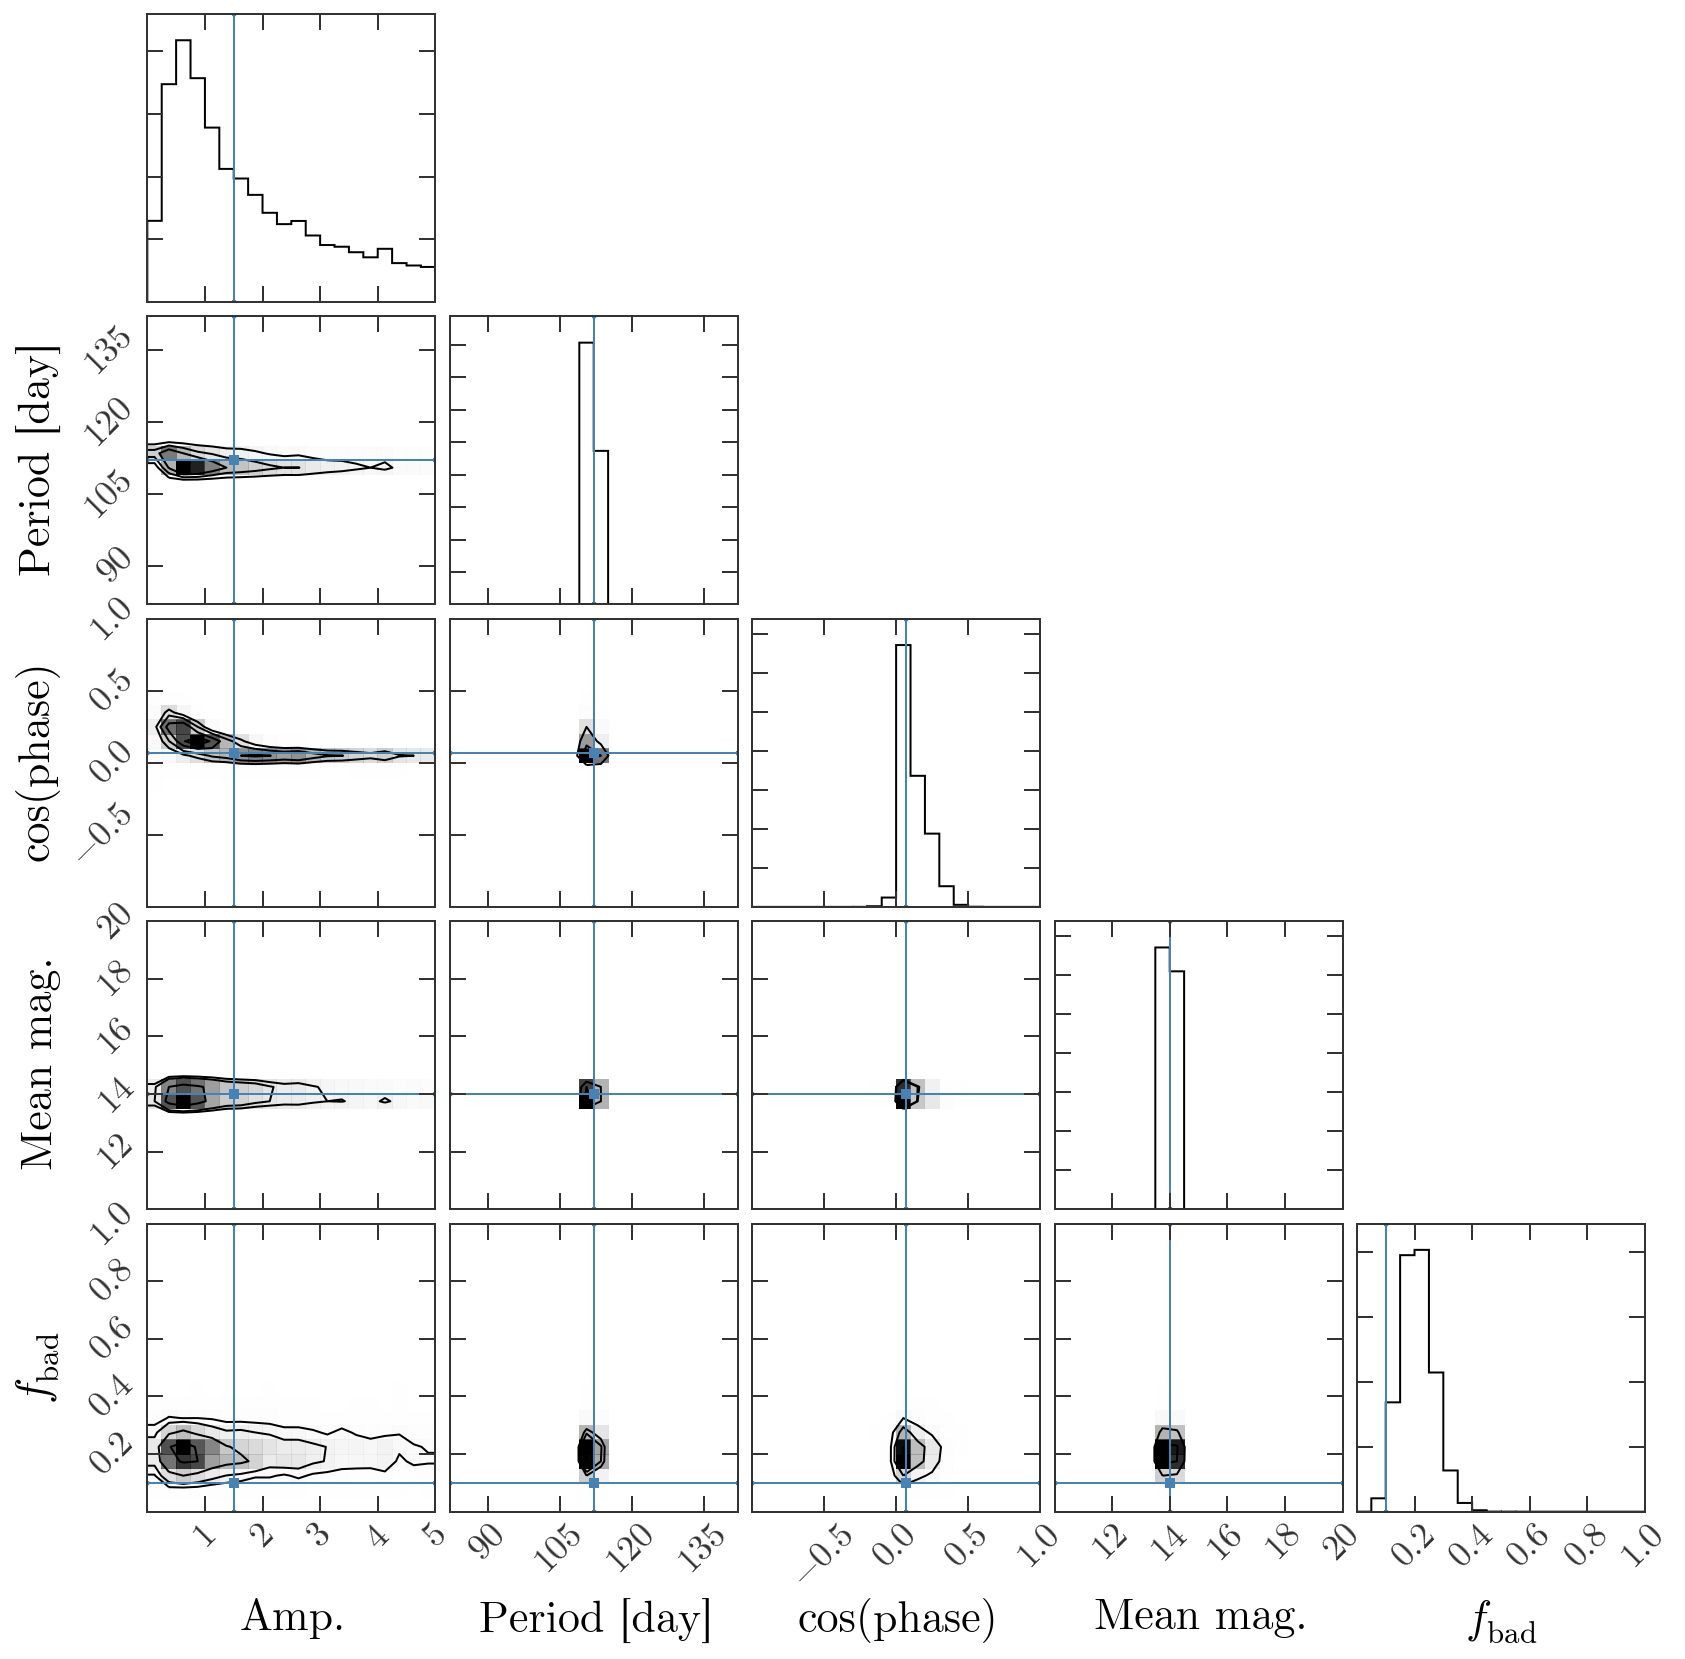

In [14]:
# Use triangle package to plot the projections of the posterior sample density and the true values 
fig = triangle.corner(sampler2.flatchain, 
                      labels=param_labels + [r"$f_{\rm bad}$"],
                      truths=list(true_params) + [0.1],
                      range=extents + [(0.,1.)],
                      plot_datapoints=False)

These results are much closer to the true values! Again, let's overplot 10 different models whose parameters are randomly chosen from these posterior samples to visualize how much better this model fits the data.

(10, 20)

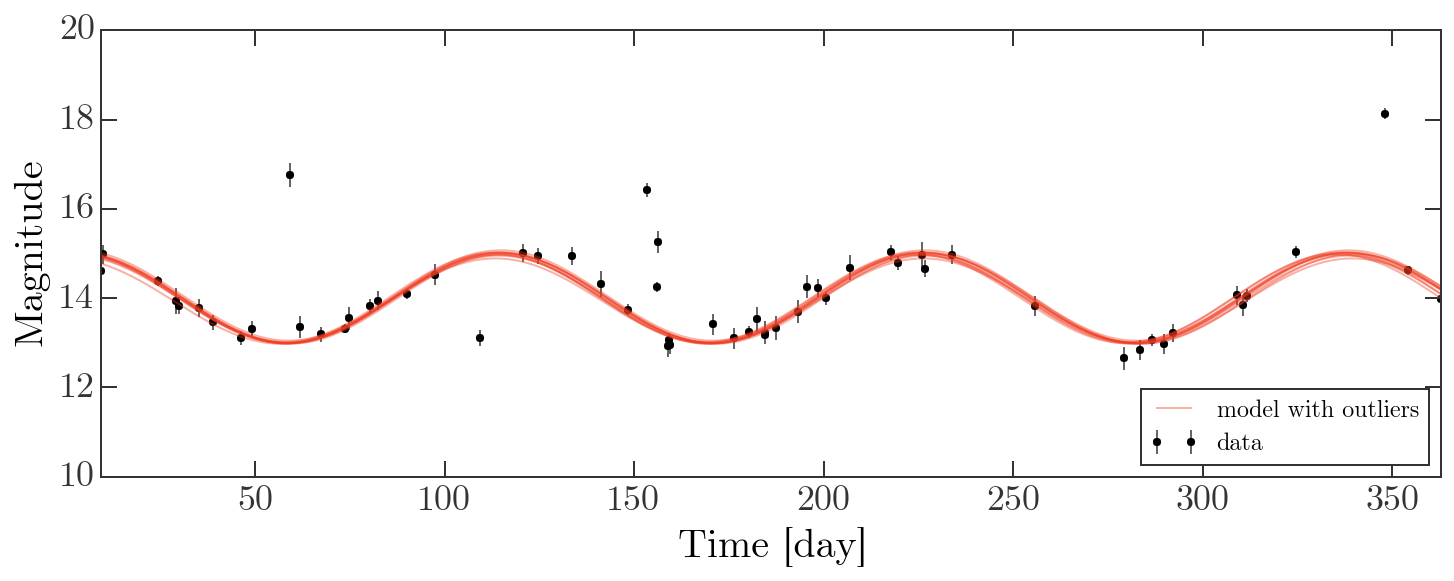

In [15]:
nsamples = sampler2.flatchain.shape[0]

plt.figure(figsize=(12,4))
plt.errorbar(time, mag, mag_err, marker='o', capsize=0, color='k', markersize=4,
             linestyle='none', ecolor='#666666', label='data')

t = np.linspace(min(time), max(time), 1000)
for model_i in range(10):
    idx = np.random.randint(0, nsamples)
    params_2 = sampler2.flatchain[idx,:4]
    model_mag_2 = light_curve_model(params_2, t)
    if model_i == 9:
        plt.plot(t, model_mag_2, 
             marker=None, color='#f03b20', alpha=0.4,label='model with outliers')
    else:
        plt.plot(t, model_mag_2, 
             marker=None, color='#f03b20', alpha=0.4)
   
plt.xlim(min(time), max(time))
plt.xlabel("Time [day]", size=20)
plt.ylabel("Magnitude", size=20)
plt.legend(loc='lower right')
plt.ylim(10,20)

Great! Looks like we have found a good model. Let's report the results using the the uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the marginalized distributions.

In [16]:
percentiles = np.percentile(sampler2.flatchain[:,:], [16, 50, 84],axis=0)
quantiles = zip(percentiles[1], percentiles[2]-percentiles[1], percentiles[1]-percentiles[0])
print 'amplitude = ',quantiles[0]
print 'period = ', quantiles[1]
print 'phase = ',quantiles[2]
print 'mean_mag = ',quantiles[3]

amplitude =  (1.3257749028361467, 1.8895881454400336, 0.80541888111146098)
period =  (111.78621617835191, 0.64505837804665589, 0.61110468725554767)
phase =  (0.088262079773661767, 0.12826300383126496, 0.05561715243809362)
mean_mag =  (13.998490265975644, 0.026693003928526693, 0.024968414493166335)


This is pretty excellent at recovering the true values of 1.5 mag, 112 days, 1.5 radians, 14 mag!

---
We need some closing, concluding words here.